In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
import csv
%matplotlib inline

def pltDefaultPar():
    #reset default matplotlib parameters for this notebook
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8

rootTP="/home/johann/Remote/imac"
rootTP2="/home/johann/Remote2"
rootMAC="/Users/jh"
root=rootMAC

In [87]:
def plotit(xlabel='\phi',legendloc=0,tofile=False,filename='test',title=''):
    plt.xlabel(r'$'+xlabel+'$')
    plt.ylabel(r'$D/D_0$')
    plt.ylim([0,1.05])
    plt.title(title)
    #plt.legend(loc=legendloc, bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.legend(loc=legendloc,fontsize = 'medium')
    if tofile==True:
        pp = PdfPages('figures/'+filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    else:
        plt.show()

In [88]:
def plotdataArr(dataArray,xlabel,lineArr,lineParam='',title='',linestyles='',setlog='',legendloc=0,tofile=False,filename=''):
    # color stuff: http://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    pltPrintPar()
    colors=cm.rainbow(np.linspace(0,1,len(dataArray)))
    if linestyles=='': lslist = len(dataArray) * ['o-']
    else: lslist = linestyles
    plt.figure()
    for i, line in enumerate(dataArray):
        ti = lineParam + str(lineArr[i])
        xs = line[:,0]
        dd0s = line[:,1]/6.
        plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
    plt.xlabel(r'$'+xlabel+'$')
    plt.ylabel(r'$D/D_0$')
    plt.ylim([0,1.3])
    plt.title(title)
    #plt.legend(loc=legendloc, bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.legend(loc=legendloc,fontsize = 'medium')
    if setlog=='y' or setlog=="double":
        plt.yscale('log')
    if setlog=='x' or setlog=="double":
        plt.xscale('log')
    if tofile==True:
        pp = PdfPages(filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    else:
        plt.show()

#### From ranRods.ipynb: Functions for all heterogeneous hydrogel obstruction models

In [4]:
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phi(aob): return (3*Vcyl(aob,b=1) - 8 * np.sqrt(2) * (aob/2.)**3)

def phiSpheres(aob):#Phi, if the fibers are modeled as spheres, not as rods
    Edgespheres = int(1./aob)
    return (3*Edgespheres-2) * 4./3 * np.pi * (aob/2)**3

def alpha(p, a):
    return phi(a,b=1)*((a+p)/a)**2

def Ogston(p, a):
    return np.exp( -(a+p)/a * np.sqrt(phi(a,b=1)))

def Johansson(p, a):
    return np.exp(-0.84 * alpha( p, a)**1.09)

def Tsai(p, a):
    return (1 + 2/3 *alpha(p, a))**-1


# For Alexa in Dextran values in nanometers
m_a=162*1.66
aexp=0.39
pexp=1.9
aop = aexp/pexp

def Cpoly(a,aexp=0.4):
    "m_a is the monomer weight, a the monomer diameter in relative units"
    Vmonomer_exp = Vcyl(aexp,aexp)
    # nmonomerPerCell = Vpolymer/Vmonomer with phi = Vpolymer/Vcell
    return m_a * phi(a,b=1) / Vmonomer_exp
atest=0.05



def CpolyFrompNoHI(p_s):
    return (p_s**3 *m_a / (aexp*(pexp+aexp)**3)) * (3 * (pexp+aexp)/p_s - 2 * aexp)
print(CpolyFrompNoHI(0.9))#WORKS!

286.86755537231954


#### In paper Phillips2000

In [4]:
# For which a do I get phi = 0.02 and phi = 0.05, like in figure 4
print("a = 0.095 -> phi = ",phi(0.095))
print("a = 0.15 -> phi = ",phi(0.15))

a = 0.095 -> phi =  0.0200521439209
a = 0.15 -> phi =  0.0482414052563


### Plot D over phi
Like in Phillips2000 figs. 1 2 3

In [5]:
def getDataFile(fileName):
    # Get data from files 
    DoverPhiFile = root + "/Documents/reports-talk-etc/reports/HIforBD/figures/"+fileName
    data = []
    with open(DoverPhiFile, 'rt') as csvfile:
        readerX = csv.reader(csvfile,delimiter=',')
        for row in readerX:
            data.append(row)
    return (np.asarray(data[1:])).astype(float)
#     with open(DoverPhiFile, 'r') as f:
#         for i, line in enumerate(f):
#             if i>1:
#                 lines = line.split()
#                 data.append([lines[0]]+lines[1])
#                 if str(lines[1]) != 'x':
#                     JasonCionRep.append(lines[0:4])

In [75]:
def getSimDataDop(aArr,aop,dt='0.001',trigger='',newlub=True,n=1):
    initfolder= root + "/Documents/workspace-cpp/SPS/Release/sim_data/noreset_oldLubBadg/fitRPinv/"+trigger
    if newlub == True:
        initfolder= root + "/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/"+trigger
    b=10
    if n!=1:
        b=n*10
    data = []
    parr=[]
    for dtdir in os.listdir(initfolder): #search smallest dt first
        folder=initfolder+"/"+dtdir+"/t200/"
        if os.path.isdir(folder):
            for j, a in enumerate(aArr):
                astr=str(a).rstrip('0').rstrip(".")
                adir="a"+astr
                p=a/aop
                pstr='%s' % float('%g' % p)
                pstr=pstr.rstrip('0').rstrip(".")
                a=(float(a)/10.)                 # make p value p/b
                p=p/10.
                if p in parr: continue
                file=os.path.join(folder, adir,'d0/b'+str(b)+'/p'+pstr+'/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt')
                #print(file)
                if os.path.isfile(file):
                    #print(file)
                    parr.append(p)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        else: print("Error: File not found!\n"+str(file))
    return (np.array(sorted(data)))

In [24]:
def getTriggerData(triggerArr,U0=0):
    triggerNameArr = []
    a=0# This if fixed here, for no HI
    datadir= root + "/Documents/workspace-cpp"
    afrac = '%g'%(float(a)/10)
    dataArr=[]
    for trigger in triggerArr:
        if trigger == 'normal':
            typedir='/SingleParticleSimulation/sim_dataOLD/noreset/dt0.0001/t200/d0/b10/'
            MSD=''
        elif trigger == 'ranRod/nrods1':
            typedir='/SingleParticleSimulation/Release/sim_data/noreset/'+trigger+'/dt0.0005/t200/d0/b10'
            MSD='MSD'
        else:
            typedir='/RanbSPS/Release/sim_data/'+trigger+'/dt0.0005/t200'
            MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir + typedir
        data = []
        for pdir in os.listdir(folder):
            file=os.path.join(folder, pdir,'k1.000/u'+str(U0)+'/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
            if os.path.isfile(file):
                p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
                p='%g'%(float(p)/10)                 # make p value p/b
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr, triggerNameArr

### Compare my Data to the analytical model by Phillips (Phillips2000)
Here, $f = (1+p/a)^2 \,\phi$ is an adjusted volume fraction. He arrives at the expression 
\begin{equation}
D/D_0 = \exp(-\alpha \phi^n)\: \exp(-0.84f^{1.09})\;,
\end{equation}
The values of $\alpha=\pi$ and $n=0.174 \ln(59.6\lambda)$ are given by Amsden1998. This is also stated in Stylianopoulos2010a.

In [7]:
def phillipsDD0(phi,aop):
    lam=aop
    n=0.174 * np.log(59.6*lam)
    f=(1+1./aop)**2 * phi
    return np.exp(-np.pi * phi**n  -  0.84*f**1.09)


### Plots for Report

Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv//dt0.001/t200/a1.4/d0/b10/p7.77778/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt
Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv//dt0.001/t200/a1.4/d0/b10/p7.77778/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt
Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv//dt0.001/t200/a1.4/d0/b10/p7.77778/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt
Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv//dt0.001/t200/a1.4/d0/b10/p7.77778/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt
Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv//dt0.001/t200/a1.4/d0/b10/p7.77778/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt
Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset

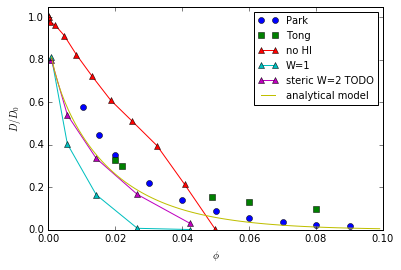

In [89]:
fileName="dataParkFig2.csv"
ExpData=getDataFile(fileName)
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Park')

fileName="dataTongFig2.csv"
ExpData2=getDataFile(fileName)
plt.plot(ExpData2[:,0],ExpData2[:,1],'s',label='Tong')

aop=0.18
aArr=np.asarray([0.2, 0.5, 0.8, 1.1, 1.4])

triggerArr = ['normal']
SimData, dummy = getTriggerData(triggerArr)
SimDataNoHI = SimData[0]
aArrNoHI = np.array([p/(1+1/aop) for p in SimDataNoHI[:,0]]) # in no HI model we use p_eff = a + p = a + a/aop
plt.plot(phi(aArrNoHI),SimDataNoHI[:,1]/6.,'^-',label='no HI')

# W=1  TOOOOODOOOO LOAD DATA FROM SHELDON
SimDatanewlub=getSimDataDop(aArr,aop)
plt.plot(phi(aArr/10.),SimDatanewlub[:,1]/6.,'^-',label='W=1')

# Just don't show noLub data at all
# # W=1 noLub
# SimDatanoLub=getSimDataDop(aArr,aop,trigger='noLub/steric')
# plt.plot(phi(aArr/10.),SimDatanoLub[:,1]/6.,'^-',label='Simulation noLub')

# n=2 line with steric ## TODO LOAD BETTER DATA FROM YOSHI FOR SOME POINTS WITH LJ
SimDatanewlubn2=getSimDataDop(aArr,aop,trigger='test/n2/steric',n=2)
plt.plot(phi(aArr/10.),SimDatanewlubn2[:,1]/6.,'^-',label='steric W=2 TODO')

# ANALYTICAL
phitest = np.arange(0.001,0.1,0.001)
plt.plot(phitest,phillipsDD0(phitest,aop),label='analytical model')

plt.xlim([0,0.1])
plotit(legendloc=0,tofile=True,filename='D_over_phi_Phil2_aop018')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/test/n2/LJ025'

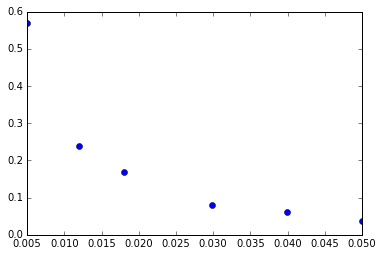

In [90]:
fileName="DataAmsdenFig3.csv"
ExpData=getDataFile(fileName)
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Amsden')

aop=0.1
aArr=np.asarray([0.25, 0.33, 0.5, 0.66, 0.91])

#W=1 data NOT RECORDED YET 
#SimData=getSimDataDop(aArr,aop,trigger='')
# plt.plot(phi(aArr/10.),SimData[:,1]/6.,'^-',label='$W=1$')

# W=2 data TODO LOAD FROM YOSHI
SimData=getSimDataDop(aArr,aop,trigger='test/n2/LJ025')
plt.plot(phi(aArr/10.),SimData[:,1]/6.,'^-',label='$W=2$')


#Analytical
phitest = np.arange(0.001,0.1,0.001)
plt.plot(phitest,phillipsDD0(phitest,aop),label='analytical model')

plt.xlim([0,0.055])
plotit(legendloc=0,tofile=True,filename='D_over_phi_Phil3_aop01')

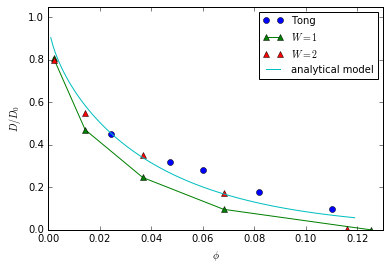

In [91]:
fileName="dataTongFig1.csv"
aop=0.32
ExpData=getDataFile(fileName)
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Tong')


# W=1 
aArr=np.asarray([0.3, 0.8, 1.3 ,1.8, 2.5])
SimDatanewlub=getSimDataDop(aArr,aop,trigger='LJ025')
plt.plot(phi(aArr/10.),SimDatanewlub[:,1]/6.,'^-',label=r'$W=1$')

### TODO get better data with LJ025 from sheldon
aArr=np.asarray([0.3, 0.8, 1.3 ,1.8, 2.4])
SimDatanewlubn2=getSimDataDop(aArr,aop,trigger='test/n2/steric',n=2)
plt.plot(phi(aArr/10.),SimDatanewlubn2[:,1]/6.,'^',label=r'$W=2$')

#Analytical
phitest = np.arange(0.001,0.12,0.001)
plt.plot(phitest,phillipsDD0(phitest,aop),label='analytical model')

plt.xlim([0,0.13])
plotit(legendloc=0,tofile=True,filename='D_over_phi_Phil1_aop032')

### Test noLub

### Test no HI data
# TODO 
- evaluate on yoshi: Fig2 noLub comparison with n_cells=2
/Users/jh/Documents/Remote_PC/yoshi_scratch/HI/sim/Release/sim_data/newlub/noreset/fitRPinv/test/n2/noLub/steric


- MAYBE: compare the analytical model by Phillips to EwaldTest1 (noLub) Data for D over phi with single monomer model

Error: File not found!
/Users/jh/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/test/n2/noLub/steric/dt0.001/t200/a1.6/d0/b20/p8.88889/k1.000/u0/InstantValues/linear_fit_parametersMSD.txt


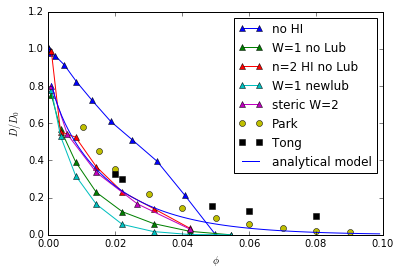

In [26]:

aop=0.18
aArrNoHI = np.array([p/(1+1/aop) for p in SimDataNoHI[:,0]]) # in no HI model we use p_eff = a + p = a + a/aop
triggerArr = ['normal']
SimData, dummy = getTriggerData(triggerArr)
SimDataNoHI = SimData[0]
plt.plot(phi(aArrNoHI),SimDataNoHI[:,1]/6.,'^-',label='no HI')

# noLub data
SimDataNoLub=getSimDataDop(aArr,aop,trigger='noLub/steric')
plt.plot(phi(aArr/10.),SimDataNoLub[:,1]/6.,'^-',label='W=1 no Lub')

# W=2: noLub data
aArrn2=np.asarray([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
SimDatan2NoLub=getSimDataDop(aArr,aop,trigger='test/n2/noLub/steric',n=2)
plt.plot(phi(aArrn2/10.),SimDatan2NoLub[:,1]/6.,'^-',label='n=2 HI no Lub')

# newlub
SimDatanewlub=getSimDataDop(aArr,aop,newlub=True)
plt.plot(phi(aArr/10.),SimDatanewlub[:,1]/6.,'^-',label='W=1 newlub')

# n=2 line with steric
aArr=np.asarray([0.2, 0.5, 0.8, 1.1, 1.4])
SimDatanewlubn2=getSimDataDop(aArr,aop,trigger='test/n2/steric',n=2)
plt.plot(phi(aArr/10.),SimDatanewlubn2[:,1]/6.,'^-',label='steric W=2')

# Experimental 
fileName="dataParkFig2.csv"
ExpData=getDataFile(fileName)
fileName="dataTongFig2.csv"
ExpData2=getDataFile(fileName)
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Park')
plt.plot(ExpData2[:,0],ExpData2[:,1],'s',label='Tong')
# ANALYTICAL
phitest = np.arange(0.001,0.1,0.001)
plt.plot(phitest,phillipsDD0(phitest,aop),label='analytical model')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.legend()
plt.show()

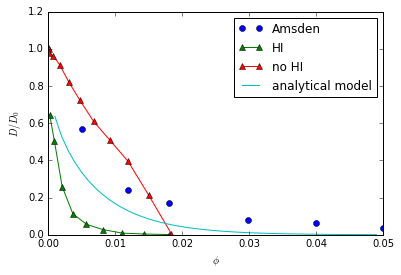

In [30]:
triggerArr = ['normal']
SimData, dummy = getTriggerData(triggerArr)
SimDataNoHI = SimData[0]
aop=0.1
aArrNoHI = np.array([p/(1+1./aop) for p in SimDataNoHI[:,0]]) # in no HI model we use p_eff = a + p = a + a/aop
# HI data
aArr=np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
SimData=getSimDataDop(aArr,aop)
# HI noLub data
fileName="DataAmsdenFig3.csv"
ExpData=getDataFile(fileName)
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Amsden')


plt.plot(phi(aArrNoHI),SimDataNoHI[:,1]/6.,'^-',label='no HI')
phitest = np.arange(0.001,0.05,0.001)
plt.plot(phitest,phillipsDD0(phitest,aop),label='analytical model')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.legend()
plt.show()

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
# OLD STUFF

### Compare analytical data to my simulation data for D over p


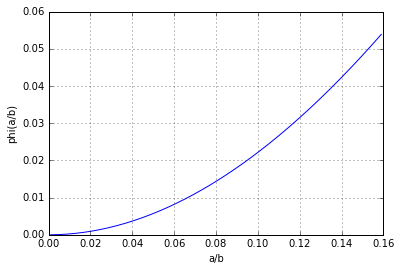

In [63]:
arels=np.arange(0.001,0.16,0.001)
plt.plot(arels,phi(arels))
plt.grid()
plt.ylabel('phi(a/b)')
plt.xlabel('a/b')
plt.show()

In [13]:
a1=0.15
print('For a='+str(a1)+' , phi =',phi(a1))


def getData_Fixa(a,u0=0,trigger='',W=1,oldLub=False,system=''):
    dataArr = []
    folder=root+"/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/"+system
    if oldLub==True:
        initfolder=root+"/Documents/workspace-cpp/SPS/Release/sim_data/noreset_oldLubBadg/fitRPinv/"+system
    b=10*W
    data=[]
    if W==1: 
        folder+="/"+trigger
    else: 
        if system=='':
            folder+="/test"
        folder+="/n"+str(W)+"/"+trigger
    folder+="/dt0.001/t200/a"+str(a)+'/d0/b'+str(b)
    data = []
    ustr=str(u0)
    for pdir in os.listdir(folder):
        file=os.path.join(folder, pdir,'k1.000/u'+ustr+'/InstantValues/linear_fit_parametersMSD.txt')
        if os.path.isfile(file):
            p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
            p='%g'%(float(p)/10)                 # make p value p/b
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        #print(file)
    return np.array(sorted(data))

For a=0.15 , phi = 0.0482414052563


### The below data needs to be re-recorded with steric!!! Otherwise the calculation of phi is wrong!

For a=0.05 , phi = 0.00571370953018


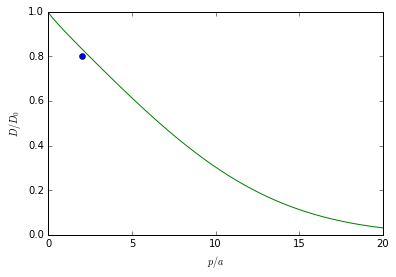

In [14]:
atest=0.5
arel=atest/10.
print('For a='+str(arel)+' , phi =',phi(arel))
arel=atest/10.
a1data=(getData_Fixa(atest))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.show()

For a=0.1 , phi = 0.0221477313396


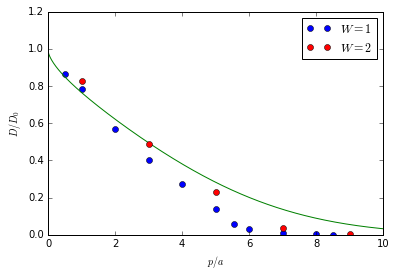

In [17]:
atest=1
arel=atest/10.
print('For a='+str(arel)+' , phi =',phi(arel))
a1data=(getData_Fixa(atest))

W=2
a1dataW2=getData_Fixa(atest,W=W)

ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o',label='$W=1$')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.plot(a1dataW2[:,0]/arel,a1dataW2[:,1]/6.,'o',label='$W=2$')
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.ylim([0,1.2])
plt.legend()
#plt.xlim([0,3.5])
plt.show()

For a=0.2 , phi = 0.0829340711087


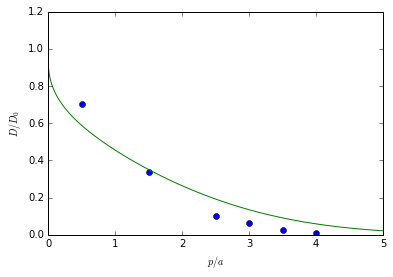

In [46]:
atest=2
arel=atest/10.
print('For a='+str(arel)+' , phi =',phi(arel))
arel=atest/10.
a1data=(getData_Fixa(atest))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.ylim([0,1.2])
plt.show()

### What if I use phiSpheres, instead of phi for cylinders? This is the actual case for the data, since I did not include steric interactions
The answer is clear below: The agreement gets even worse. This is unsurprising, since the actual phi is even smaller and thus the diffusivities calculated by Phillips2000 are even larger.

The *good* thing is: I now see, that the W=2 case agrees better with the analytical model *as it should!*

In conclusion: The plots above are not valid: They have to be re-recorded with steric!

For a=0.1 , phi = 0.0221477313396


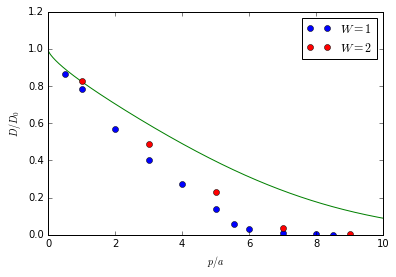

In [22]:
atest=1
arel=atest/10.
print('For a='+str(arel)+' , phi =',phi(arel))
a1data=(getData_Fixa(atest))

W=2
a1dataW2=getData_Fixa(atest,W=W)

ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o',label='$W=1$')
plt.plot(ptest/atest,phillipsDD0(phiSpheres(arel),atest/ptest))
plt.plot(a1dataW2[:,0]/arel,a1dataW2[:,1]/6.,'o',label='$W=2$')
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.ylim([0,1.2])
plt.legend()
#plt.xlim([0,3.5])
plt.show()

For a=0.2 , phi = 0.0829340711087


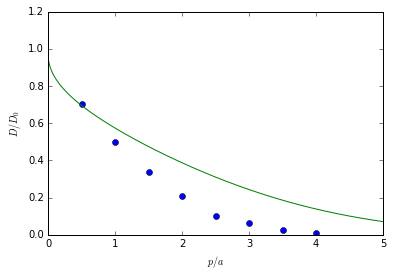

In [24]:
atest=2
arel=atest/10.
print('For a='+str(arel)+' , phi =',phi(arel))
arel=atest/10.
a1data=(getData_Fixa(atest))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o')
plt.plot(ptest/atest,phillipsDD0(phiSpheres(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.ylim([0,1.2])
plt.show()

### Same with noLub
Here, **steric is activated**: Hence, I no not use phiSpheres, but the phi for cylinders

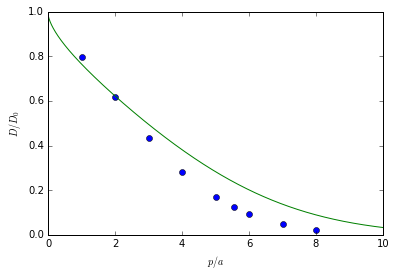

In [48]:
atest=1
arel=atest/10.
a1data=(getData_Fixa(atest,trigger='noLub/steric'))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.show()

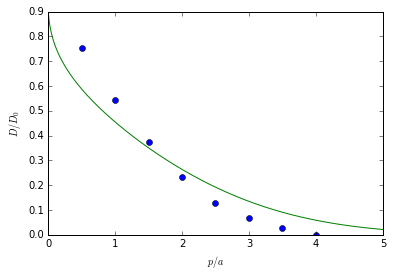

In [23]:
atest=2
arel=atest/10.
a1data=(getData_Fixa(atest,trigger='noLub/steric'))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.show()

#### noLub and $U_0=-1k_BT$

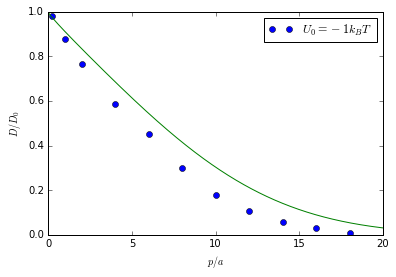

In [52]:
atest=0.5
arel=atest/10.
a1data=(getData_Fixa(atest,u0=-1,trigger='noLub/steric'))
ptest=np.arange(0.01,10,0.01)
plt.plot(a1data[:,0]/arel,a1data[:,1]/6.,'o',label='$U_0=-1k_BT$')
plt.plot(ptest/atest,phillipsDD0(phi(arel),atest/ptest))
plt.ylabel('$D/D_0$')
plt.xlabel('$p/a$')
plt.legend()
plt.show()